In [1]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300
from matplotlib.pyplot import figure, show, subplots
from matplotlib import pyplot as plt

import numpy as np
import subprocess
import os


import netCDF4 as nc
import csv
import toml
from tomlkit import dumps
from tomlkit import parse
from tomlkit import inline_table

#import yaml
from ruamel.yaml import YAML
yaml = YAML()
yaml.preserve_quotes = True  # Keep quotes if they exist
yaml.indent(mapping=2, sequence=4, offset=2)  # Preserve indentation
yaml.representer.add_representer(
    float, lambda dumper, data: dumper.represent_scalar("tag:yaml.org,2002:float", str(data))
)

with open("../config/masterconfig.yaml", "r") as file:
    config = yaml.load(file) or {}
AGNI_rootpath = config['AGNI_rootpath']
AGNI_outputpath = config['AGNI_outputpath']
SOCRATES_path = config['SOCRATES_path']
REPO_path = config['REPO_path']# the path of the LIFEredoxsurvey repo

In [6]:
filepath = "../output/atmospheres_mole.csv"
mole_data = np.genfromtxt(filepath,skip_header=1,delimiter=',')[:,2:]
coords = np.genfromtxt(filepath,skip_header=1,delimiter=',')[:,:2]
titles = np.genfromtxt(filepath,dtype=str,delimiter=',')[0][2:]

In [3]:
def input_volatiles(filepath,volatile_dict):

    # open toml file
    with open(filepath, "r") as f:
        toml_str = f.read()
    doc = parse(toml_str)

    # input volatile dictionary
    my_table = inline_table()
    for key, value in volatile_dict.items():
        my_table[key] = value
    my_table.trivia.trail = "\n"
    doc["composition"]["vmr_dict"] = my_table

    # write to toml file
    with open(filepath, "w") as f:
        f.write(dumps(doc))  # Use str() to serialize back to TOML

def write_data(filepath,bandcenter,intensity):
    with open(filepath, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(['bandcenter','intensity',])
        for i in range(len(bandcenter)):
            string = [str(bandcenter[i]),str(intensity[i])]
            writer.writerow(string)

In [ ]:
for i in range(len(mole_data)):
    # insert atmosphere and run AGNI
    dictionary = dict(zip(titles, mole_data[i]))
    input_volatiles("../config/LIFE_spectra.toml",dictionary)
    prompt = "export RAD_DIR=" + SOCRATES_path + ";./agni.jl " + REPO_path + "/config/LIFE_spectra.toml"
    subprocess.run(prompt,cwd=AGNI_rootpath, shell=True)

    # read out emission data
    AGNI_out = AGNI_outputpath + "/atm.nc"
    ds = nc.Dataset(AGNI_out)
    bandmin_data = ds['bandmin'][:]
    bandmax_data = ds['bandmax'][:]
    bandcenter = (bandmin_data + bandmax_data)/2 * 10**9
    bandwidth = (bandmax_data - bandmin_data) * 10**9
    lw_data = ds['ba_U_LW'][:]
    sw_data = ds['ba_U_SW'][:]
    bandflux = (lw_data[1, :] + sw_data[1, :]) / bandwidth * 1000

    # save text file
    csvname = '../output/AGNI/AGNI_textfiles/AGNI_spectrum_' + str(round(coords[i][0],2)) + '_' + str(round(coords[i][1],2)) + '.csv'
    write_data(csvname, bandcenter,bandflux)

The latest version of Julia in the `release` channel is 1.11.5+0.x64.linux.gnu. You currently have `1.11.4+0.x64.linux.gnu` installed. Run:

  juliaup update

in your terminal shell to install Julia 1.11.5+0.x64.linux.gnu and update the `release` channel to that version.
  Activating project at `/dataserver/users/formingworlds/borgmann/AGNI`


[ INFO  ] Using configuration 'LIFE_spectra' 
[ INFO  ] Setting-up a new atmosphere struct 
[ INFO  ] Loading thermodyamic data 
[ INFO  ] Inserting stellar spectrum and Rayleigh coefficients 
[ INFO  ] Allocating atmosphere with composition: 
[ INFO  ]       1 N2      3.56e-03 (EOS_VDW) 
[ INFO  ]       2 CO      1.85e-02 (EOS_VDW) 
[ INFO  ]       3 H2      1.41e-02 (EOS_CMS19) 
[ INFO  ]       4 CH4     1.10e-12 (EOS_VDW) 
[ INFO  ]       5 H2S     2.66e-02 (EOS_VDW) 
[ INFO  ]       6 S2      2.01e-01 (NO_OPACITY EOS_IDEAL) 
[ INFO  ]       7 SO2     3.10e-01 (EOS_VDW) 
[ INFO  ]       8 H2O     2.79e-01 (EOS_AQUA) 
[ INFO  ]       9 CO2     1.48e-01 (EOS_VDW) 
[ INFO  ]      10 O2      6.70e-10 (NO_OPACITY EOS_VDW) 
[ INFO  ] Setting T(p): dry, sat 
[ INFO  ] Solving with 'none' 
[ INFO  ]     done 
[ INFO  ] Total RT evalulations: 2 
[ INFO  ] Writing results 
[ INFO  ] Plotting results 
[ INFO  ] Deallocating memory 
[ INFO  ] Model runtime: 44.41 seconds 


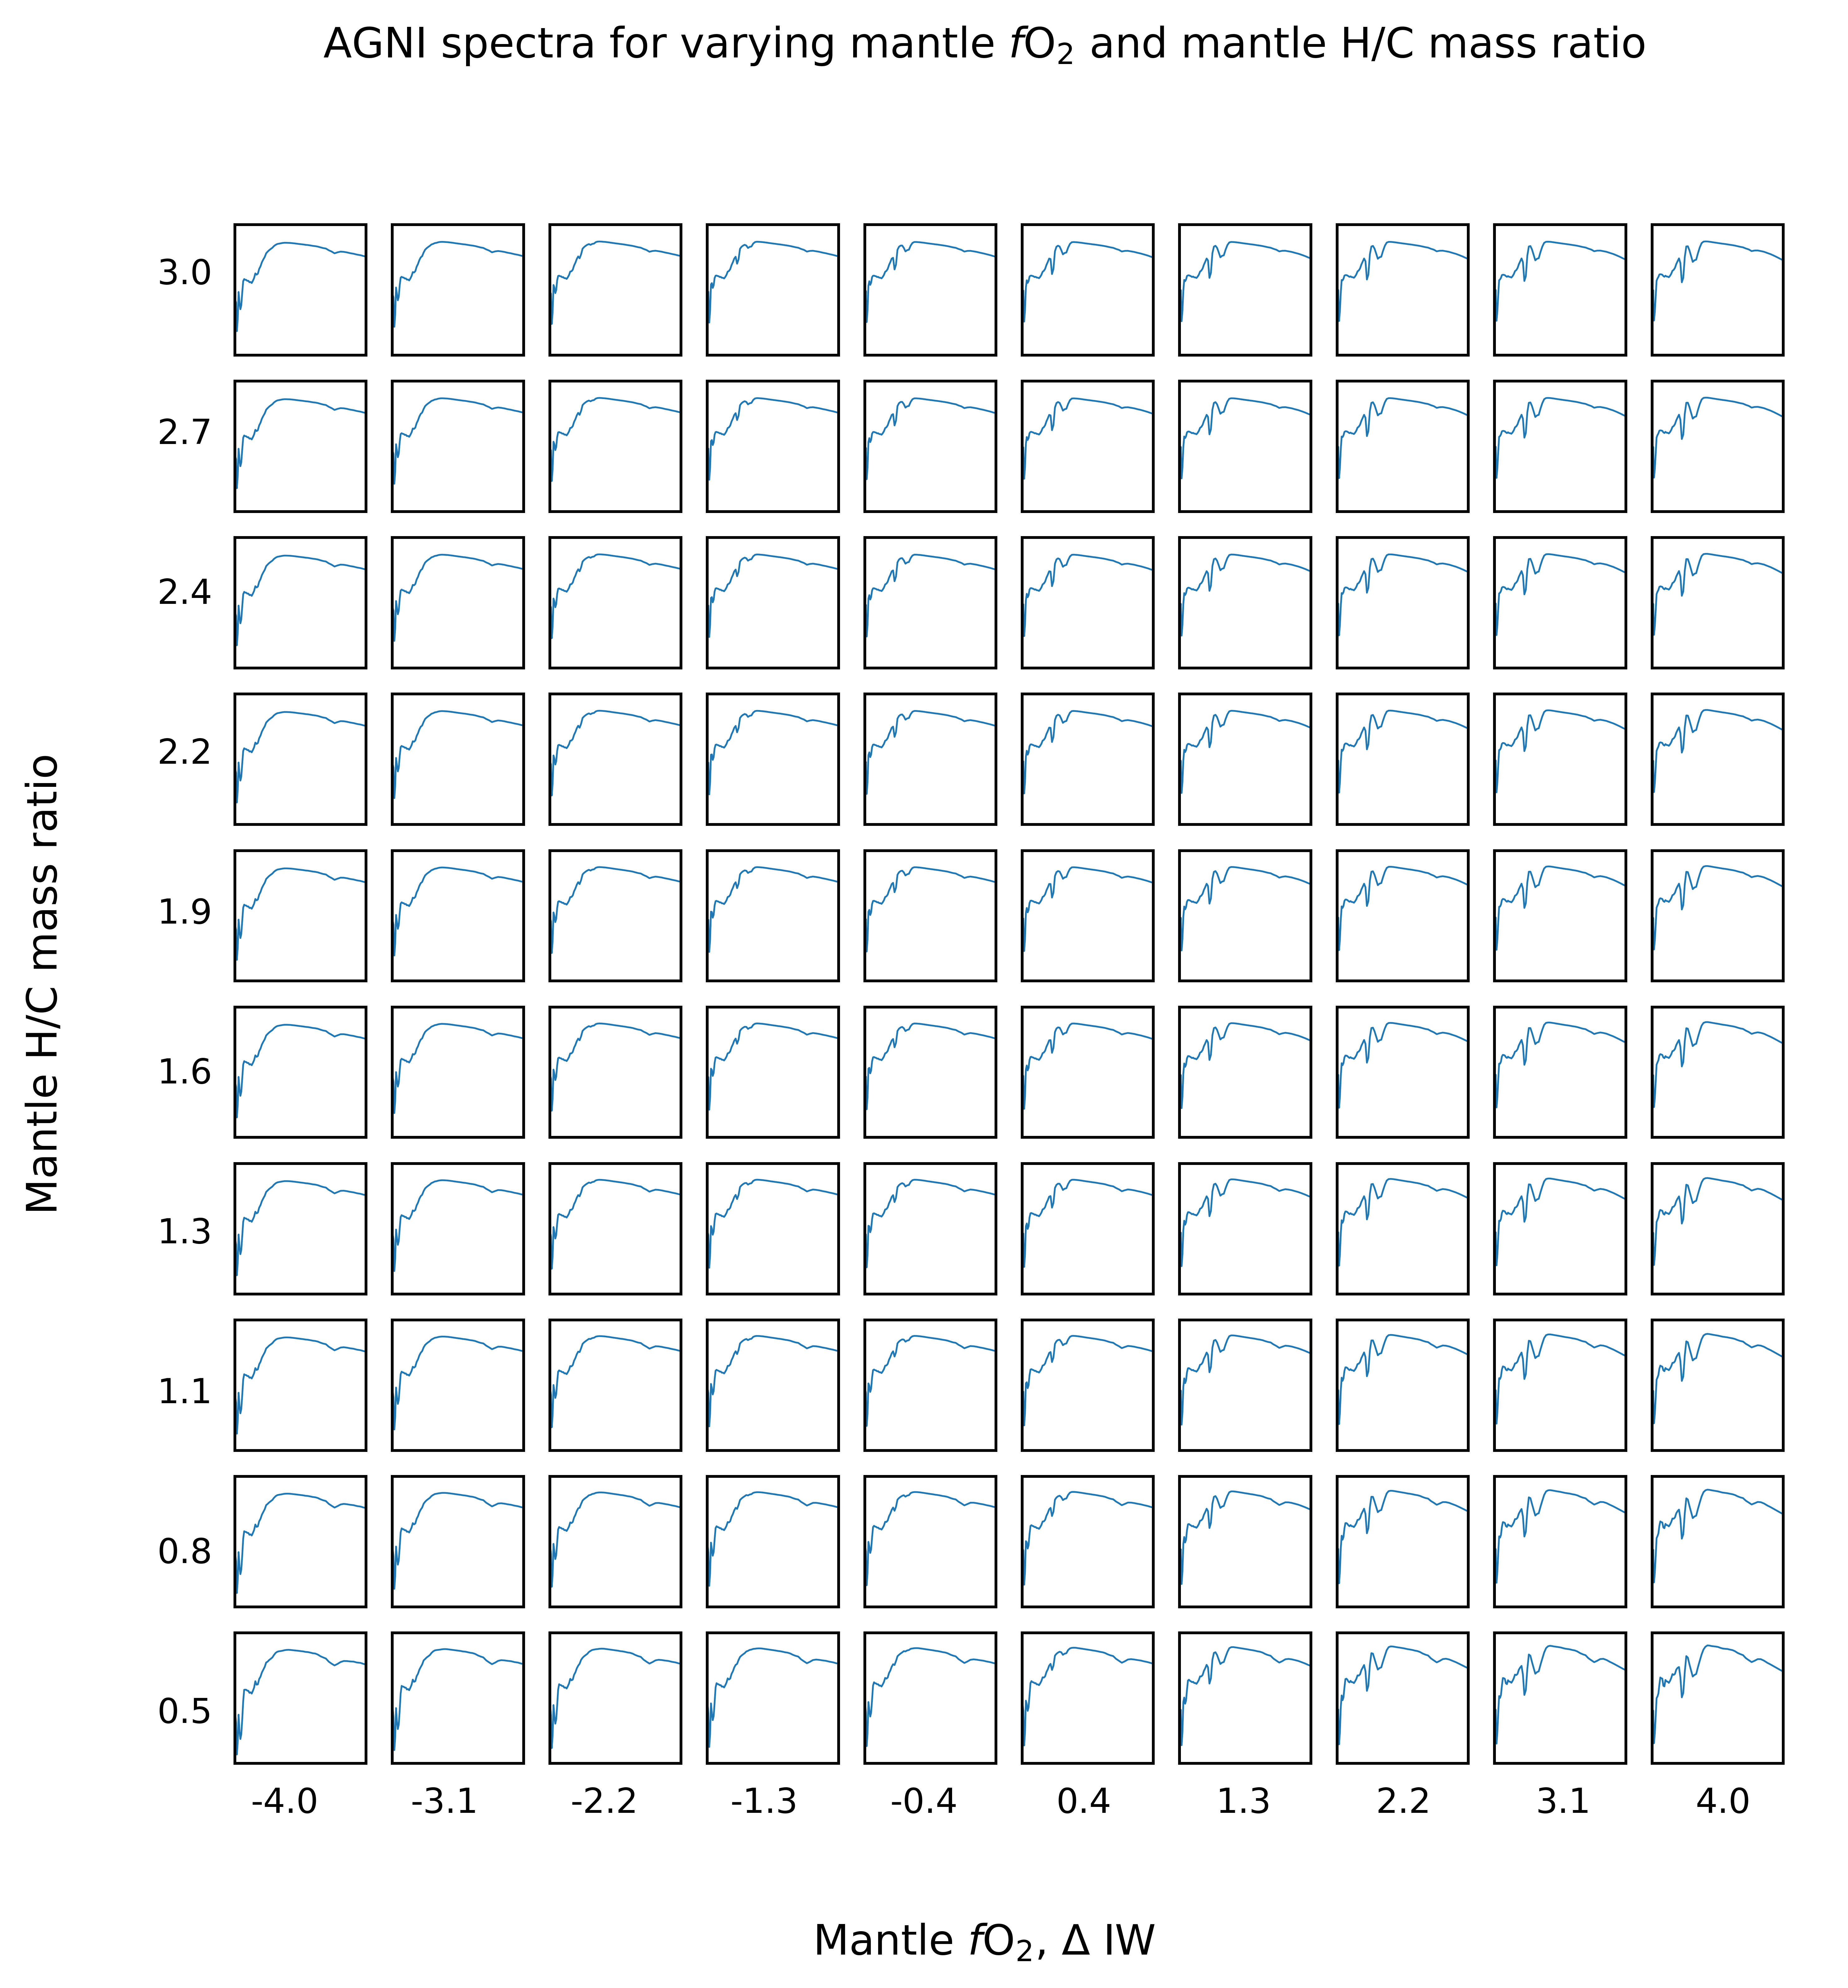

In [33]:
# raster plot

custom_order = []
for i in range(1,11):
    #print(i)
    custom_order.append(np.arange(90+i,i-10,-10))
custom_order = np.array(custom_order).flatten()
data_path = "../output/AGNI/AGNI_textfiles"
files = [f for f in os.listdir(data_path)]

mpl.rcParams['figure.dpi'] = 800
rasterplot = figure(figsize=(8,8))

for i in range(len(files)):
    image_path = data_path + "/" + files[i]
    bandcenter = np.genfromtxt(image_path,skip_header=1,delimiter=",")[:,0]
    bandflux = np.genfromtxt(image_path,skip_header=1,delimiter=",")[:,1]
    # bandflux_error = np.genfromtxt(image_path,skip_header=1,delimiter=",",dtype=list)[:,1]
    # bandflux = []
    # for j in range(len(bandflux_error)):
    #     bandflux.append(float(bandflux_error[j].decode('utf8')[1:-1]))
    frame = rasterplot.add_subplot(10,10,custom_order[i])
    frame.plot(bandcenter/1000,bandflux,linewidth=0.5)
    #frame.set_xlim(max(1.0e-10,min(bandcenter)), min(max(bandcenter), 70000.0))
    #frame.set_ylim(max(1.0e-10,min(bandflux)) / 2, max(bandflux) * 2)
    #frame1.set_xscale('log')
    frame.set_yscale('log')
    frame.set_xlim(4,18.5)
    frame.set_ylim(0.05,40)
    frame.set_yticklabels([])
    frame.set_xticklabels([])
    frame.set_xticks([])
    frame.set_yticks([])
    frame.minorticks_off()


    #frame.axis('off')

for j in range(10):
    left = 0.1 + j * 0.08
    ax = rasterplot.add_axes([left, 0.075, 0.1, 0.03])  # [left, bottom, width, height]
    ax.text(0.5, 0.5, str(round(coords[j*10][0],1)), ha='center', va='center')
    ax.axis('off')

for i in range(10):
    bottom = 0.1 + (9 - i) * 0.08
    ax = rasterplot.add_axes([0.1, bottom, 0.0, 0.07])
    ax.text(0.5, 0.5, str(round(coords[-i-1][1],1)), ha='center', va='center')
    ax.axis('off')

rasterplot.supxlabel('Mantle $f$O$_2$, $\Delta$ IW')
rasterplot.supylabel('Mantle H/C mass ratio')
rasterplot.suptitle("AGNI spectra for varying mantle $f$O$_2$ and mantle H/C mass ratio")
rasterplot.show()
rasterplot.savefig('../output/figures/AGNI_rasterplot.png')
mpl.rcParams['figure.dpi'] = 300


[13  9  5  1 14 10  6  2 15 11  7  3 16 12  8  4]


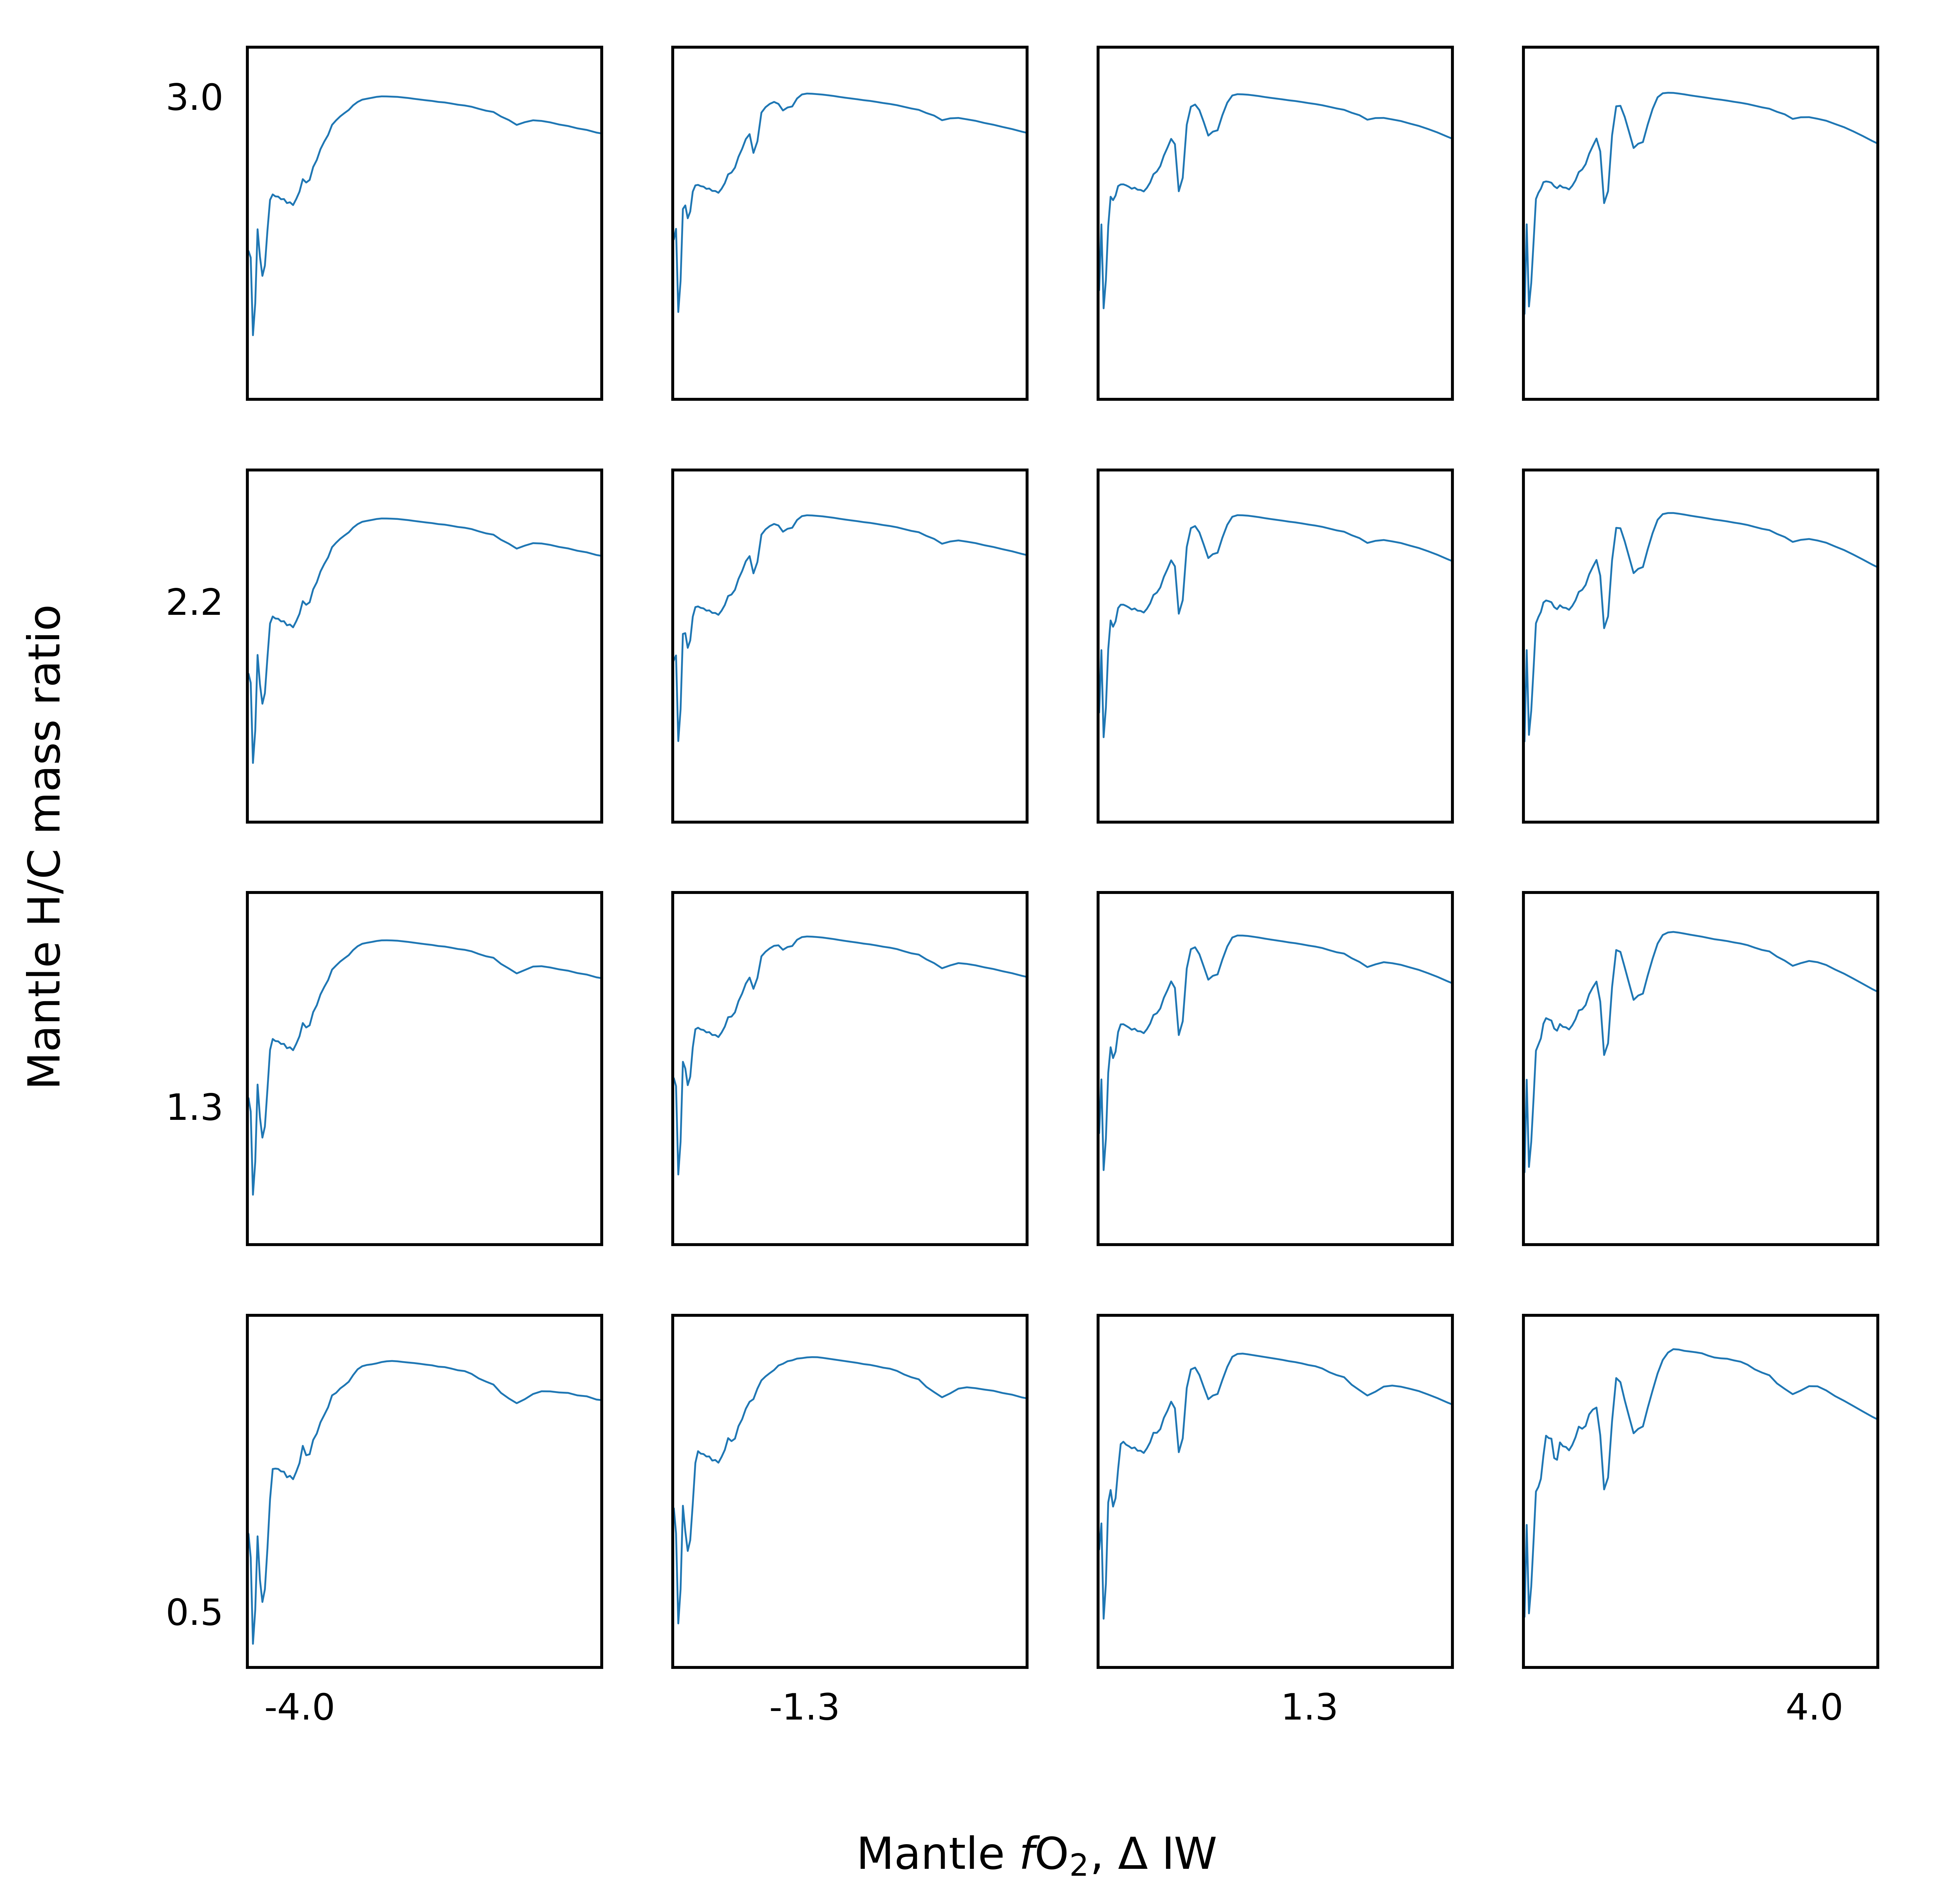

In [ ]:
# raster plot zoomed into 4,4 grid
# unused function, only for my own personal presentation
def rasterplot_zoom():
    sixteen_indices = [0,3,6,9,30,33,36,39,60,63,66,69,90,93,96,99]
    custom_order = []
    for i in range(1,5):
        #print(i)
        custom_order.append(np.arange(12+i,i-4,-4))
    custom_order = np.array(custom_order).flatten()
    print(custom_order)
    data_path = "../output/AGNI/AGNI_textfiles"
    files = [f for f in os.listdir(data_path)]

    mpl.rcParams['figure.dpi'] = 800
    rasterplot = figure(figsize=(8,8))

    for i in range(len(sixteen_indices)):
        image_path = data_path + "/" + files[sixteen_indices[i]]
        bandcenter = np.genfromtxt(image_path,skip_header=1,delimiter=",")[:,0]
        bandflux = np.genfromtxt(image_path,skip_header=1,delimiter=",")[:,1]
        frame = rasterplot.add_subplot(4,4,custom_order[i])
        frame.plot(bandcenter/1000,bandflux,linewidth=0.5)
        frame.set_yscale('log')
        frame.set_xlim(4,18.5)
        frame.set_ylim(0.05,40)
        frame.set_yticklabels([])
        frame.set_xticklabels([])
        frame.set_xticks([])
        frame.set_yticks([])
        frame.minorticks_off()

    for j in range(4):
        left = 0.1 + j * (0.72 / 3)  # Spread over 0.72 total width, like original 9*0.08
        ax = rasterplot.add_axes([left, 0.075, 0.1, 0.03])  # [left, bottom, width, height]
        ax.text(0.5, 0.5, str([-4.0,-1.3,1.3,4.0][j]), ha='center', va='center')
        ax.axis('off')

    for i in range(4):
        # Distribute labels from top to bottom over the same vertical range
        bottom = 0.1 + (3 - i) * (0.72 / 3)  # i from 0 to 3
        ax = rasterplot.add_axes([0.1, bottom, 0.0, 0.07])
        ax.text(0.5, 0.5, str([3.0,2.2,1.3,0.5][i]), ha='center', va='center')
        ax.axis('off')

    rasterplot.supxlabel('Mantle $f$O$_2$, $\Delta$ IW')
    rasterplot.supylabel('Mantle H/C mass ratio')
    #rasterplot.suptitle("AGNI spectra for varying mantle $f$O$_2$ and mantle H/C mass ratio")
    rasterplot.show()
    rasterplot.savefig('../output/figures/AGNI_rasterplot.png')
    mpl.rcParams['figure.dpi'] = 300

[4.  0.5]


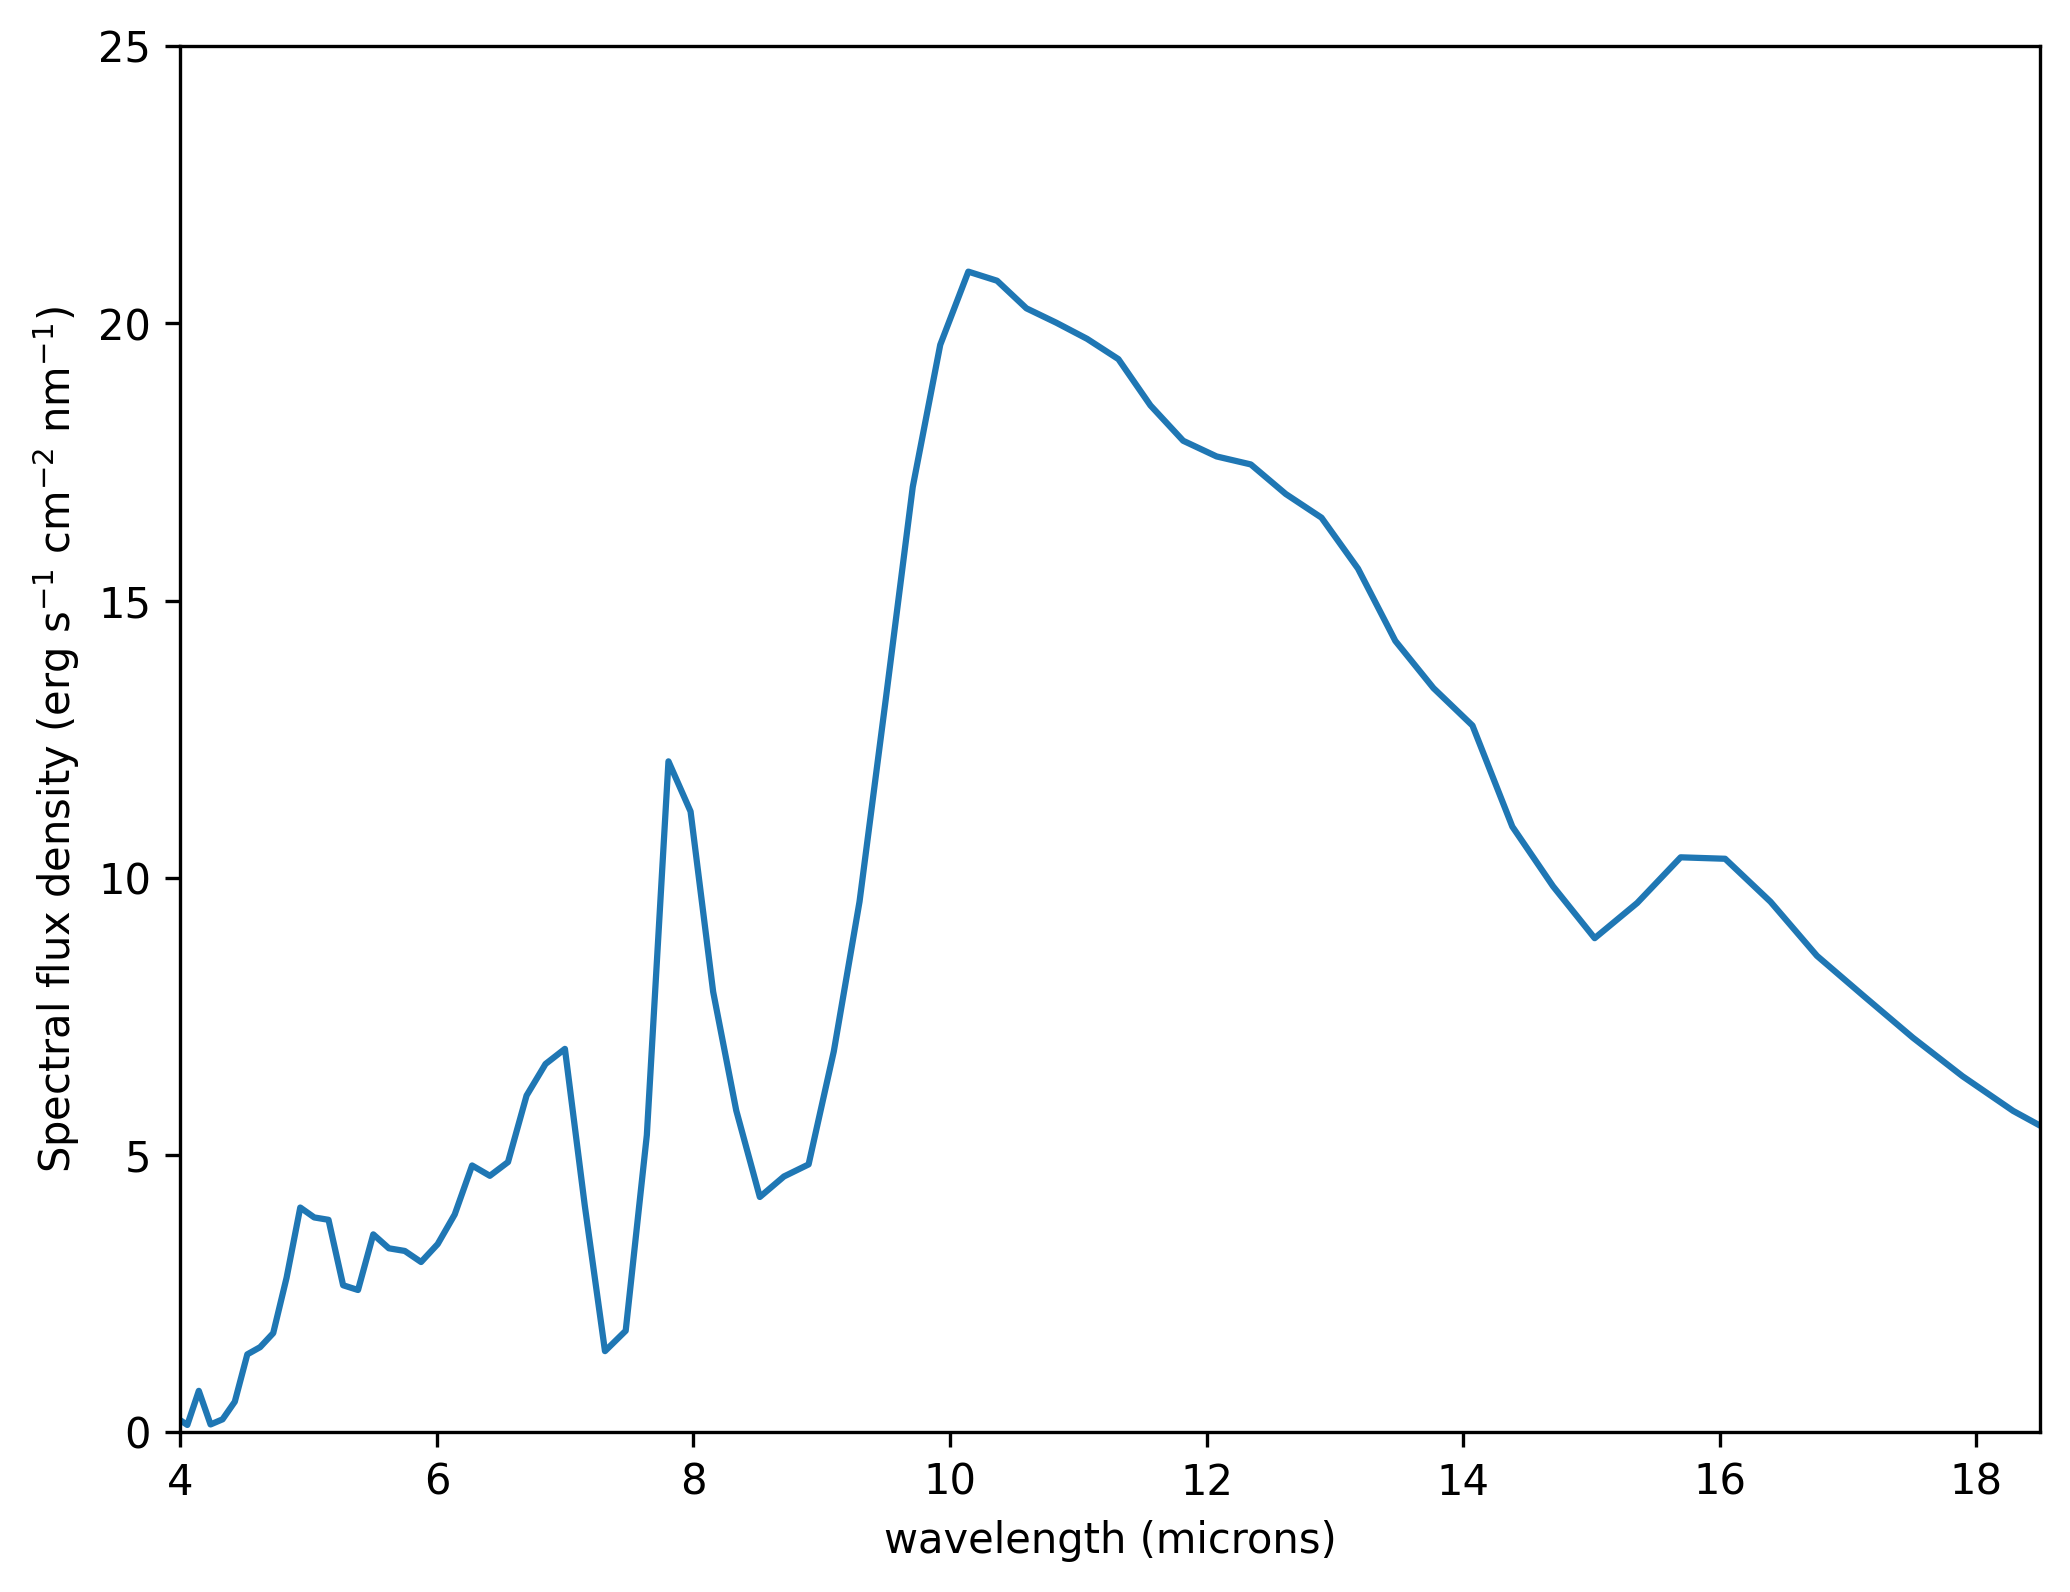

In [ ]:
# save individual images
plt.ioff() # supress notebook output

data_path = "../output/AGNI/AGNI_textfiles"
files = [f for f in os.listdir(data_path)]

mpl.rcParams['figure.dpi'] = 300

for i in range(len(files)):
#for i in [90]:
    image_path = data_path + "/" + files[i]
    bandcenter = np.genfromtxt(image_path,skip_header=1,delimiter=",")[:,0]
    bandflux = np.genfromtxt(image_path,skip_header=1,delimiter=",")[:,1]

    fig = figure(figsize=(8,6))
    frame1 = fig.add_subplot(1,1,1)
    frame1.plot(bandcenter/1000,bandflux)
    frame1.set_xlabel('wavelength (microns)')
    frame1.set_ylabel('Spectral flux density (erg s$^{-1}$ cm$^{-2}$ nm$^{-1}$)')
    #frame1.set_xscale('log')
    frame1.set_yscale('log')
    frame1.set_xlim(4,18.5)
    frame1.set_ylim(0.05,40)
    pngname = '../output/AGNI/AGNI_spectra/AGNI_spectrum_' + str(round(coords[i][0],2)) + '_' + str(round(coords[i][1],2)) + '.png'
    fig.savefig(pngname)